<a href="https://colab.research.google.com/github/xelothi/CRAF_for_a_paper/blob/main/maccs_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Testing different ML model's ability to predict CRAF inhibitory molecules based on MACCS fingerprints.

In [ ]:
! pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 36.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics,svm, clone
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split,KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, Descriptors, rdFingerprintGenerator, AllChem, MACCSkeys
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
df = pd.read_csv("df_train.csv", index_col=[0])
df.head()

,Unnamed: 0,molecule_chembl_id,std_smiles,MW,LogP,NumHDonors,NumHAcceptors,numRotatingBonds,norm_value,pIC50,bioactivity
77,77,CHEMBL3092186,Cc1c(Cc2cccc(NS(N)(=O)=O)c2)c(=O)oc2cc(OC(=O)N...,449.460,2.50712,2.0,6.0,5.0,180.0,6.744727,inactive
416,416,CHEMBL1778406,CNC(=O)c1cc(Oc2ccc3sc(Nc4ccc(C)cc4)nc3c2)ccn1,390.468,4.89522,2.0,6.0,5.0,7.0,8.154902,inactive
191,191,CHEMBL5084985,COc1cccc(-c2nc3sccn3c2-c2ccnc(NCCNS(=O)(=O)c3c...,520.640,4.22722,2.0,9.0,9.0,163.0,6.787812,inactive
394,394,CHEMBL513600,CNC(=O)c1cc(Oc2ccc3c(c2)nc(Nc2ccc(Br)cc2)n3C)ccn1,452.312,4.62630,2.0,6.0,5.0,1.0,9.000000,inactive
204,204,CHEMBL5092007,O=S(=O)(NCCNc1nccc(-c2c(-c3ccccc3)nc3sccn23)n1...,492.586,3.61580,3.0,9.0,8.0,75.0,7.124939,inactive


In [ ]:
df["activity"] = df["bioactivity"].apply(lambda x: 1 if x == "active" else 0)
df.shape

(300, 12)

In [ ]:
df["activity"].value_counts()

activity
0    209
1     91
Name: count, dtype: int64

In [ ]:
df = df.dropna()
df.shape

(300, 12)

In [ ]:
def smiles_to_fp(smiles, method="maccs", n_bits=32784):


    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=n_bits)
        return np.array(fpg.GetFingerprint(mol))
    if method == "morgan3":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=n_bits)
        return np.array(fpg.GetFingerprint(mol))
    else:
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [ ]:
df["fp"] = df["std_smiles"].apply(smiles_to_fp)
df.head(3)

,Unnamed: 0,molecule_chembl_id,std_smiles,MW,LogP,NumHDonors,NumHAcceptors,numRotatingBonds,norm_value,pIC50,bioactivity,activity,fp
77,77,CHEMBL3092186,Cc1c(Cc2cccc(NS(N)(=O)=O)c2)c(=O)oc2cc(OC(=O)N...,449.460,2.50712,2.0,6.0,5.0,180.0,6.744727,inactive,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
416,416,CHEMBL1778406,CNC(=O)c1cc(Oc2ccc3sc(Nc4ccc(C)cc4)nc3c2)ccn1,390.468,4.89522,2.0,6.0,5.0,7.0,8.154902,inactive,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
191,191,CHEMBL5084985,COc1cccc(-c2nc3sccn3c2-c2ccnc(NCCNS(=O)(=O)c3c...,520.640,4.22722,2.0,9.0,9.0,163.0,6.787812,inactive,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


# Feature selection
Performing basic feature selection using Pearson correalation. Threshold set is 0.7.

In [ ]:
fingerprint_to_model = df.fp.tolist()
label_to_model = df.activity.tolist()
SEED = 42

X_train,X_test, Y_train, Y_test = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=SEED)

from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler()
X_train, Y_train = undersampler.fit_resample(X_train, Y_train)

splits = [X_train, X_test, Y_train, Y_test]
print("Training data size:", len(X_train))
print("Test data size:", len(X_test))

Training data size: 144
Test data size: 60


In [ ]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)
    rmse = mean_squared_error(test_y, test_pred)

    if verbose:
        # Print performance results
        print(f"Accuracy: {accuracy:.2f}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")
        print(f"RMSE: {rmse:.2f}")

    return accuracy, sens, spec, auc,rmse

In [ ]:
def model_training_and_validation(ml_model, name, splits, verbose=True):
    train_x, test_x, train_y, test_y = splits

    # Fit the model
    ml_model = ml_model.fit(train_x, train_y)
    # Calculate model performance results
    accuracy, sens, spec, auc,rmse = model_performance(ml_model, test_x, test_y, verbose)
    return accuracy, sens, spec, auc,rmse

In [ ]:
def plot_roc_curves_for_models(models, test_x, test_y, save_png=False):

    fig, ax = plt.subplots()

    # Below for loop iterates through models list
    for model in models:
        # Select the model
        ml_model = model["model"]
        # Prediction probability on test set
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        # Prediction class on test set
        test_pred = ml_model.predict(test_x)
        # Compute False postive rate and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(test_y, test_prob)
        # Plot the computed values
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.2f}"))

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")

#Random Forest

In [ ]:
SEED=23

Hyperparameter tuning of Random forest using GridSearch

In [ ]:
model_RF = RandomForestClassifier(random_state=SEED)
param_grid = {
    "n_estimators": np.arange(1,210, 1),
    "max_depth": np.arange(1,6,1),
    "criterion": ["gini", "entropy"]
}
grid = GridSearchCV(estimator=model_RF, param_grid=param_grid, scoring="accuracy", verbose=10, n_jobs=1, cv=5)
grid_res = grid.fit(X_train, Y_train)

Streaming output truncated to the last 5000 lines.
[CV 1/5; 1591/2090] START criterion=entropy, max_depth=3, n_estimators=128......
[CV 1/5; 1591/2090] END criterion=entropy, max_depth=3, n_estimators=128;, score=0.724 total time=   0.2s
[CV 2/5; 1591/2090] START criterion=entropy, max_depth=3, n_estimators=128......
[CV 2/5; 1591/2090] END criterion=entropy, max_depth=3, n_estimators=128;, score=0.724 total time=   0.2s
[CV 3/5; 1591/2090] START criterion=entropy, max_depth=3, n_estimators=128......
[CV 3/5; 1591/2090] END criterion=entropy, max_depth=3, n_estimators=128;, score=0.724 total time=   0.2s
[CV 4/5; 1591/2090] START criterion=entropy, max_depth=3, n_estimators=128......
[CV 4/5; 1591/2090] END criterion=entropy, max_depth=3, n_estimators=128;, score=0.552 total time=   0.2s
[CV 5/5; 1591/2090] START criterion=entropy, max_depth=3, n_estimators=128......
[CV 5/5; 1591/2090] END criterion=entropy, max_depth=3, n_estimators=128;, score=0.821 total time=   0.2s
[CV 1/5; 1592/

In [ ]:
print(f"Best parametars are {grid_res.best_params_} with score of {grid_res.best_score_}")

Best parametars are {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 63} with score of 0.7369458128078817


In [ ]:
splits = [X_train, X_test, Y_train, Y_test]
# Set model parameter for random forest
model_RF = RandomForestClassifier(random_state=SEED)
param = {
    "n_estimators": 15,
    "max_depth": 5,
    "criterion": "gini",
}
performance_measures = model_training_and_validation(model_RF, "RF", splits)

Accuracy: 0.83
Sensitivity: 0.79
Specificity: 0.85
AUC: 0.95
RMSE: 0.17


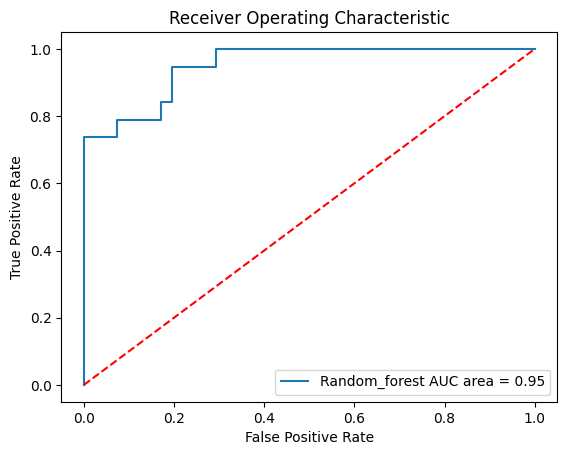

In [ ]:
models = [{"label": "Random_forest", "model": model_RF}]
plot_roc_curves_for_models(models, X_test, Y_test)

# K-nearest Neighbor

Choosing the best number of neighbors

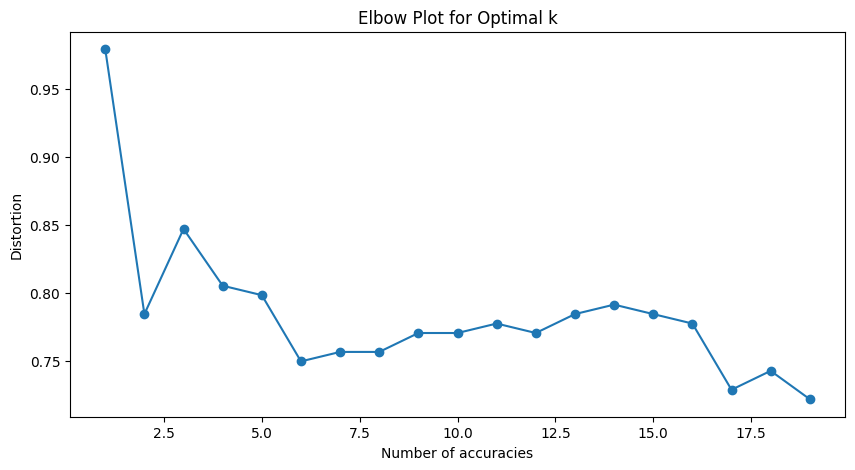

In [ ]:
def best_k(splits, num_k):
 X_train, X_test, y_train,y_test = splits
 distortions = []

 for k in range(1, num_k):
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)
        distortions.append(model.score(X_train, y_train))

 plt.figure(figsize=(10,5))
 plt.plot(range(1,num_k), distortions, marker='o')
 plt.xlabel('Number of accuracies')
 plt.ylabel('Distortion')
 plt.title('Elbow Plot for Optimal k')

best_k(splits, 20)

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=15)
performance_measures_knn = model_training_and_validation(knn_model, "KNN_model", splits)

Accuracy: 0.85
Sensitivity: 0.84
Specificity: 0.85
AUC: 0.92
RMSE: 0.15


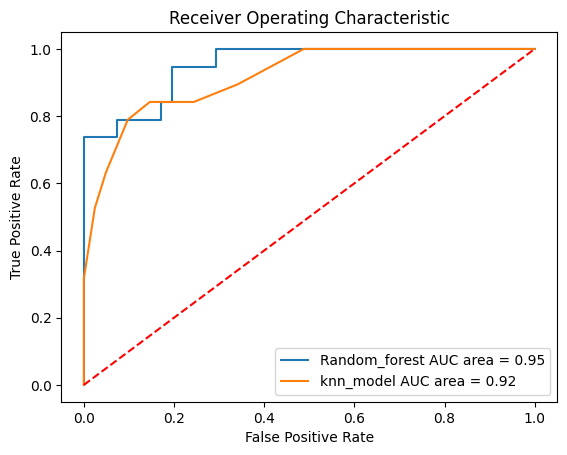

In [ ]:
models.append({"label": "knn_model", "model": knn_model})
plot_roc_curves_for_models(models, X_test, Y_test)

#XGBoost

In [ ]:
xgb = XGBClassifier()
performance_measures_xg = model_training_and_validation(xgb, "XGB", splits)

Accuracy: 0.83
Sensitivity: 0.79
Specificity: 0.85
AUC: 0.91
RMSE: 0.17


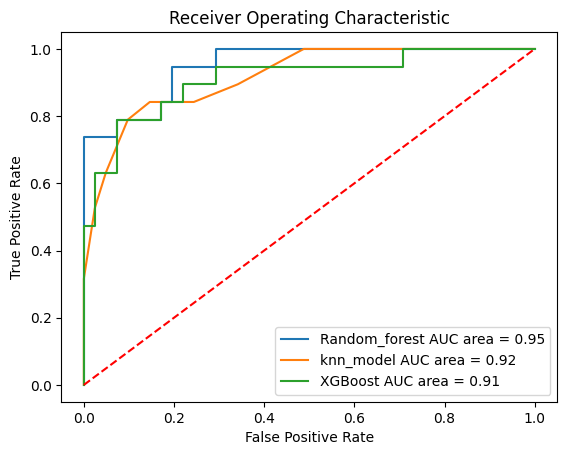

In [ ]:
models.append({"label": "XGBoost", "model": xgb})
plot_roc_curves_for_models(models, X_test, Y_test)

#SVM

In [ ]:
model_SVM = svm.SVC(kernel="rbf", C=1, gamma=0.1, probability=True)

performance_measures_svm_no = model_training_and_validation(model_SVM, "SVM", splits)

Accuracy: 0.88
Sensitivity: 0.84
Specificity: 0.90
AUC: 0.96
RMSE: 0.12


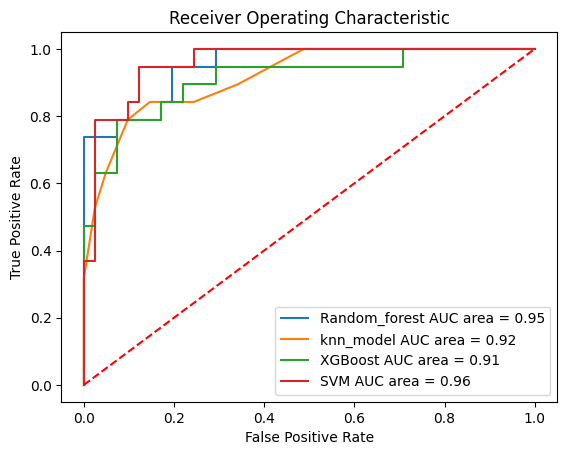

In [ ]:
models.append({"label": "SVM", "model": model_SVM})
plot_roc_curves_for_models(models, X_test, Y_test)

# Artificial Neural Networks

In [ ]:
mlp = MLPClassifier(random_state=0,max_iter=2000).fit(X_train, Y_train)
performance_measures_mlp = model_training_and_validation(mlp, "mlp", splits)

Accuracy: 0.85
Sensitivity: 0.84
Specificity: 0.85
AUC: 0.95
RMSE: 0.15


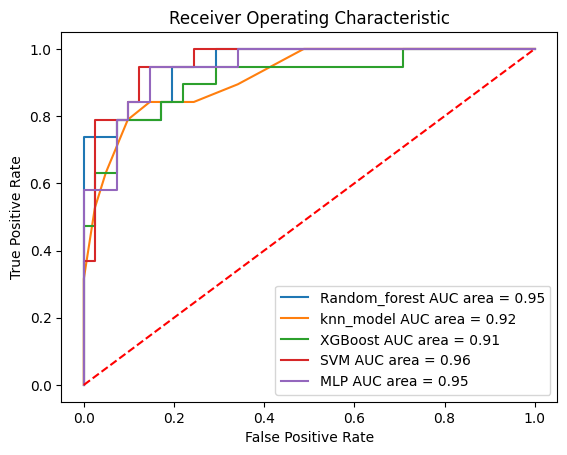

In [ ]:
models.append({"label": "MLP", "model": mlp})
plot_roc_curves_for_models(models, X_test, Y_test)

# Cross validation

In [ ]:
def crossvalidation(model, df, n_folds, verbose=False):

    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    acc = []
    sen = []
    spe = []
    AUC = []
    RMSE = []



    for train_index, test_index in kfold.split(df):
        fold_model = clone(model)

        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].activity.tolist()

        train_x, train_y = undersampler.fit_resample(train_x, train_y)
        fold_model.fit(train_x, train_y)


        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].activity.tolist()

        accuracy, sens, spec, auc, rmse = model_performance(fold_model, test_x, test_y, verbose)
        acc.append(accuracy)
        sen.append(sens)
        spe.append(spec)
        AUC.append(auc)
        RMSE.append(rmse)


    print(f"Mean accuracy: {np.mean(acc):.2f} \t"
        f"and std : {np.std(acc):.2f} \n"
        f"Mean sensitivity: {np.mean(sen):.2f} \t"
        f"and std : {np.std(sen):.2f} \n"
        f"Mean specificity: {np.mean(spe):.2f} \t"
        f"and std : {np.std(spe):.2f} \n"
        f"Mean AUC: {np.mean(AUC):.2f} \t"
        f"and std : {np.std(AUC):.2f} \n"
        f"Mean RMSE: {np.mean(RMSE):.2f} \t"
        f"and std : {np.std(RMSE):.2f} \n"

    )
    mean_acc = np.mean(acc)
    mean_sen = np.mean(sen)
    mean_spec = np.mean(spec)
    mean_AUC = np.mean(AUC)
    mean_RMSE = np.mean(RMSE)

    return [mean_acc, mean_sen, mean_spec, mean_AUC, mean_RMSE]


In [ ]:
cross_val = {}
for model in models:
    print("\n======= ")
    print(f"{model['label']}")
    m = crossvalidation(model["model"], df, n_folds=10)
    label = model['label']
    cross_val[label] = m


Random_forest
Mean accuracy: 0.79 	and std : 0.06 
Mean sensitivity: 0.76 	and std : 0.14 
Mean specificity: 0.81 	and std : 0.07 
Mean AUC: 0.86 	and std : 0.07 
Mean RMSE: 0.21 	and std : 0.06 


knn_model
Mean accuracy: 0.76 	and std : 0.07 
Mean sensitivity: 0.71 	and std : 0.11 
Mean specificity: 0.77 	and std : 0.08 
Mean AUC: 0.85 	and std : 0.05 
Mean RMSE: 0.24 	and std : 0.07 


XGBoost
Mean accuracy: 0.75 	and std : 0.07 
Mean sensitivity: 0.72 	and std : 0.09 
Mean specificity: 0.75 	and std : 0.06 
Mean AUC: 0.84 	and std : 0.06 
Mean RMSE: 0.25 	and std : 0.07 


SVM
Mean accuracy: 0.80 	and std : 0.06 
Mean sensitivity: 0.72 	and std : 0.07 
Mean specificity: 0.84 	and std : 0.08 
Mean AUC: 0.84 	and std : 0.05 
Mean RMSE: 0.20 	and std : 0.06 


MLP
Mean accuracy: 0.81 	and std : 0.07 
Mean sensitivity: 0.79 	and std : 0.12 
Mean specificity: 0.82 	and std : 0.09 
Mean AUC: 0.89 	and std : 0.07 
Mean RMSE: 0.19 	and std : 0.07 



In [ ]:
df2 = pd.DataFrame(cross_val, index=["Accuracy", "Sensitivity", "Specificity", "AUC", "RMSE"])
df2 = df2.T
df2

,Accuracy,Sensitivity,Specificity,AUC,RMSE
Random_forest,0.786667,0.755150,0.791667,0.863033,0.213333
knn_model,0.756667,0.714060,0.750000,0.845291,0.243333
XGBoost,0.746667,0.720150,0.750000,0.843646,0.253333
SVM,0.803333,0.719038,0.833333,0.840588,0.196667
MLP,0.806667,0.786560,0.833333,0.890184,0.193333


Text(0.5, 1.0, 'Model performances after K-fold cross-validation')

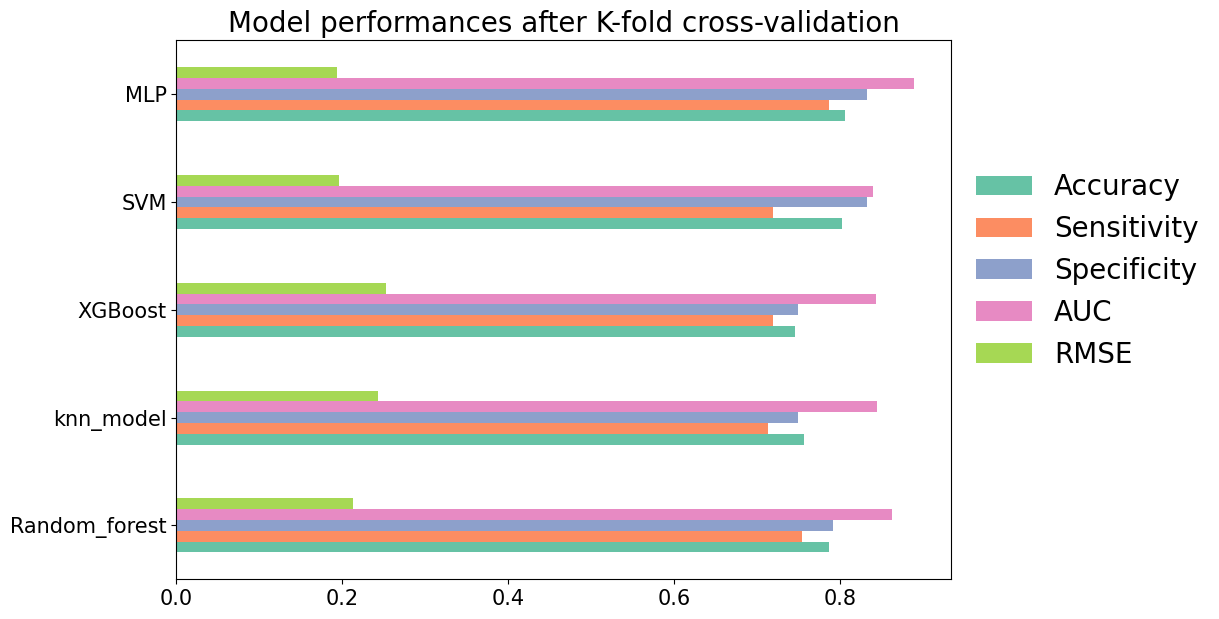

In [ ]:
color=sns.color_palette('Set2')
feat = ["Accuracy","Sensitivity", "Specificity", "AUC", "RMSE"]
df2[feat].plot.barh(figsize=(10,7),color=color)
plt.legend(frameon=False,bbox_to_anchor=(1,0.8), prop={'size':20})
plt.xticks(size=15)
plt.yticks(size=15)
plt.title('Model performances after K-fold cross-validation',size=20)

# Stacking ensemble models
Choosing the three best performing models and turning them into ensembl model.

In [ ]:
estimators = [("RandomForest", model_RF), ("KNN", knn_model), ("XGBoost", xgb)]
stack_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

measure_performance_stack = model_training_and_validation(stack_model, "Stack_model", splits)

Accuracy: 0.87
Sensitivity: 0.89
Specificity: 0.85
AUC: 0.94
RMSE: 0.13


Stacked model performs slightly better than the other single ML models.

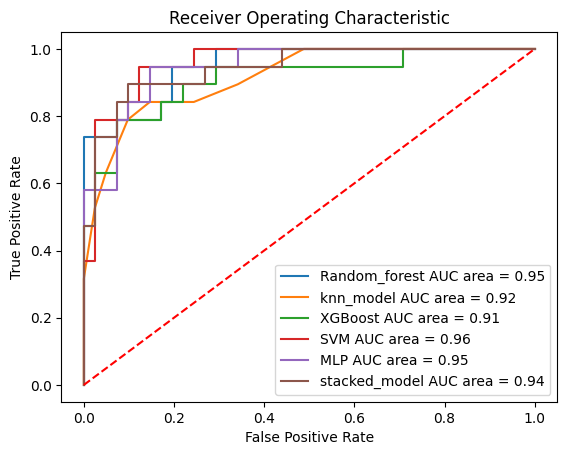

In [ ]:
models.append({"label": "stacked_model", "model": stack_model})
plot_roc_curves_for_models(models, X_test, Y_test)

Crossvalidation of the stack_model

In [ ]:
crossvalidation(stack_model, df,10)

In [ ]:
import pickle

with open('stack_model.pkl', 'wb') as file:
    pickle.dump(stack_model, file)

In [ ]:
models

[{'label': 'Random_forest', 'model': RandomForestClassifier(random_state=23)},
 {'label': 'knn_model', 'model': KNeighborsClassifier(n_neighbors=15)},
 {'label': 'XGBoost',
  'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None,
                num_parallel_tree=None, random_state=None, ...)},
 {'label': 'SVM', 'model': SVC(C=1, 

In [ ]:
xgboost_model = models[2]['model']

In [ ]:
xgboost_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
import pickle

with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(xgboost_model, file)